<a href="https://colab.research.google.com/github/HomantoFeng/ML-for-Employee-Attrition-Prediction/blob/main/Coursera_supervisedlearning_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import packages

In [1]:
# Import packages
### YOUR CODE HERE ###
# For data import from Kaggle
from google.colab import files
# For data manipulation
import numpy as np
import pandas as pd

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For displaying all of the columns in dataframes
pd.set_option('display.max_columns', None)

# For data modeling
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# For metrics and helpful functions
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree

# For saving models
import pickle

### Mount google drive to import kaggle personal KPI and copy to hidden local folder

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
# ! mkdir ~/.kaggle. (uncomment this line when running for the 1st time)
! cp /content/drive/MyDrive/Kaggle_KPI/kaggle.json ~/.kaggle/kaggle.json
! chmod 600 ~/.kaggle/kaggle.json

### Import data from Kaggle

In [7]:
!kaggle datasets download mfaisalqureshi/hr-analytics-and-job-prediction
!unzip hr-analytics-and-job-prediction.zip

Dataset URL: https://www.kaggle.com/datasets/mfaisalqureshi/hr-analytics-and-job-prediction
License(s): CC0-1.0
Archive:  hr-analytics-and-job-prediction.zip
  inflating: HR_comma_sep.csv        


### Load data

In [8]:
# RUN THIS CELL TO IMPORT YOUR DATA.
# Load dataset into a dataframe
df0 = pd.read_csv("HR_comma_sep.csv")
# Display first few rows of the dataframe
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


### Data cleaning

#### This step includes: First, finding NaN or missing values in any of the columns. Second, identifying and removing duplicated rows were identified.

In [ ]:
df0.describe()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.238083,0.021268
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.425924,0.144281
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [ ]:
df0.isna().sum()

,0
satisfaction_level,0
last_evaluation,0
number_project,0
average_montly_hours,0
time_spend_company,0
Work_accident,0
left,0
promotion_last_5years,0
Department,0
salary,0


In [34]:
df0.duplicated().sum()

np.int64(3008)

In [9]:
# Drop duplicates and save resulting dataframe in a new variable as needed
df1 = df0.drop_duplicates(keep='first')
# Display first few rows of new dataframe as needed
df1.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [15]:
# correct mis-spelled column name
df1 = df1.rename(columns={'average_montly_hours': 'average_monthly_hours'})

### Data Exploration and Visualizations

#### Check data balance

In [16]:
display(df1['left'].value_counts(normalize=True) * 100)

,proportion
left,
0,83.39588
1,16.60412


##### By summarizing the ‘left’ column, I found that the dataset has an approximately 83%-17% split: 16.6% of employees have left the company, while 83.4% have not. Although the data is somewhat imbalanced, the imbalance is not severe.

### Data Visulization

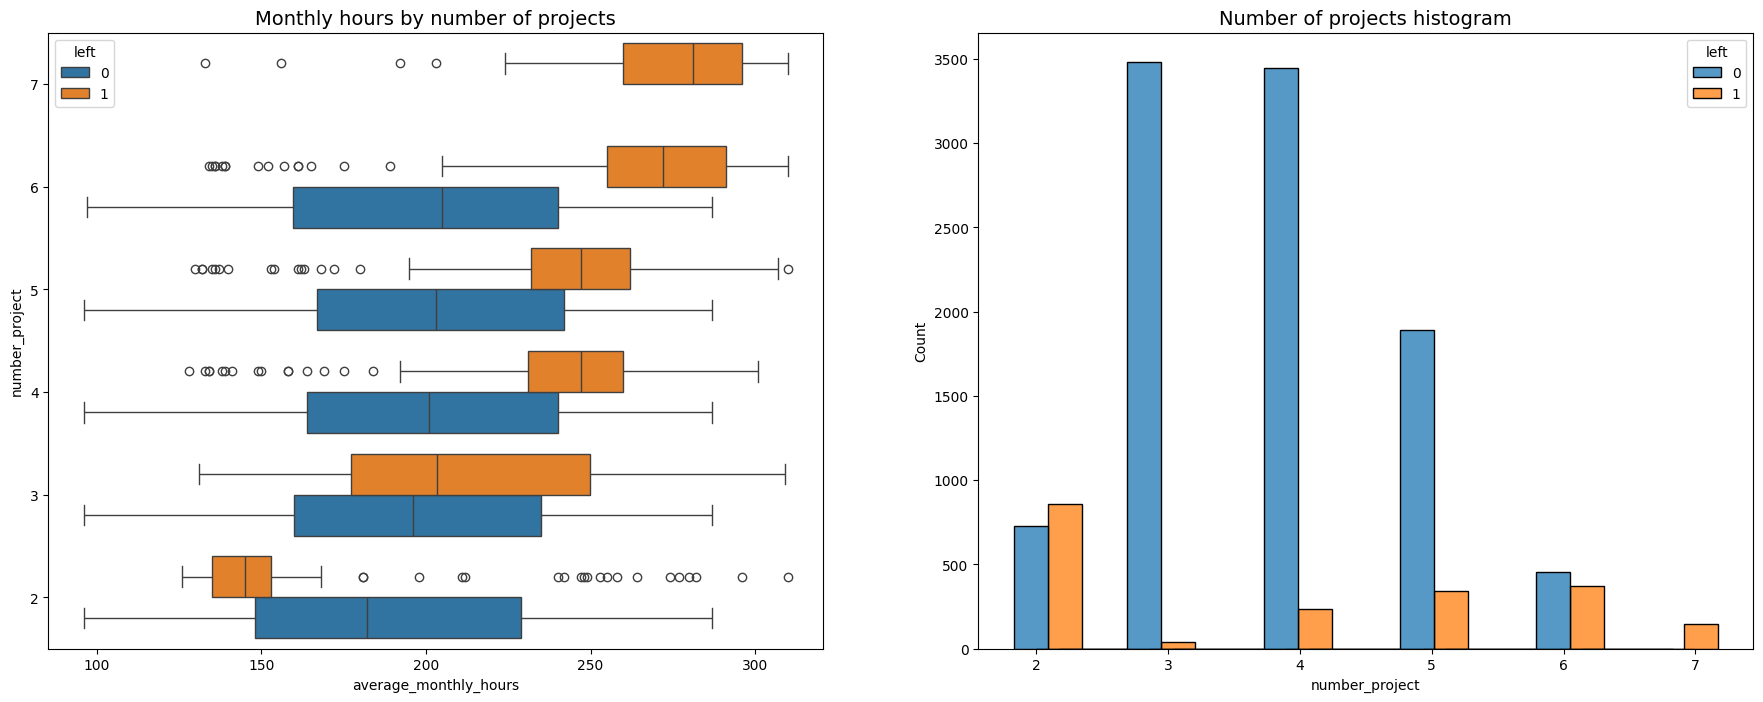

In [20]:
# Set figure and axes
fig, ax = plt.subplots(1, 2, figsize = (22,8))

# Create boxplot showing `average_monthly_hours` distributions for `number_project`, comparing employees who stayed versus those who left
sns.boxplot(data=df1, x='average_monthly_hours', y='number_project', hue='left', orient="h", ax=ax[0])
ax[0].invert_yaxis()
ax[0].set_title('Monthly hours by number of projects', fontsize='14')

# Create histogram showing distribution of `number_project`, comparing employees who stayed versus those who left
tenure_stay = df1[df1['left']==0]['number_project']
tenure_left = df1[df1['left']==1]['number_project']
sns.histplot(data=df1, x='number_project', hue='left', multiple='dodge', shrink=3, ax=ax[1])
ax[1].set_title('Number of projects histogram', fontsize='14')

# Display the plots
plt.show()

Observation 1. Everyone with seven projects left the company;  2. The optimal number of projects for employees to work on seems to be 3–4. The ratio of left/stayed is very small for these cohorts

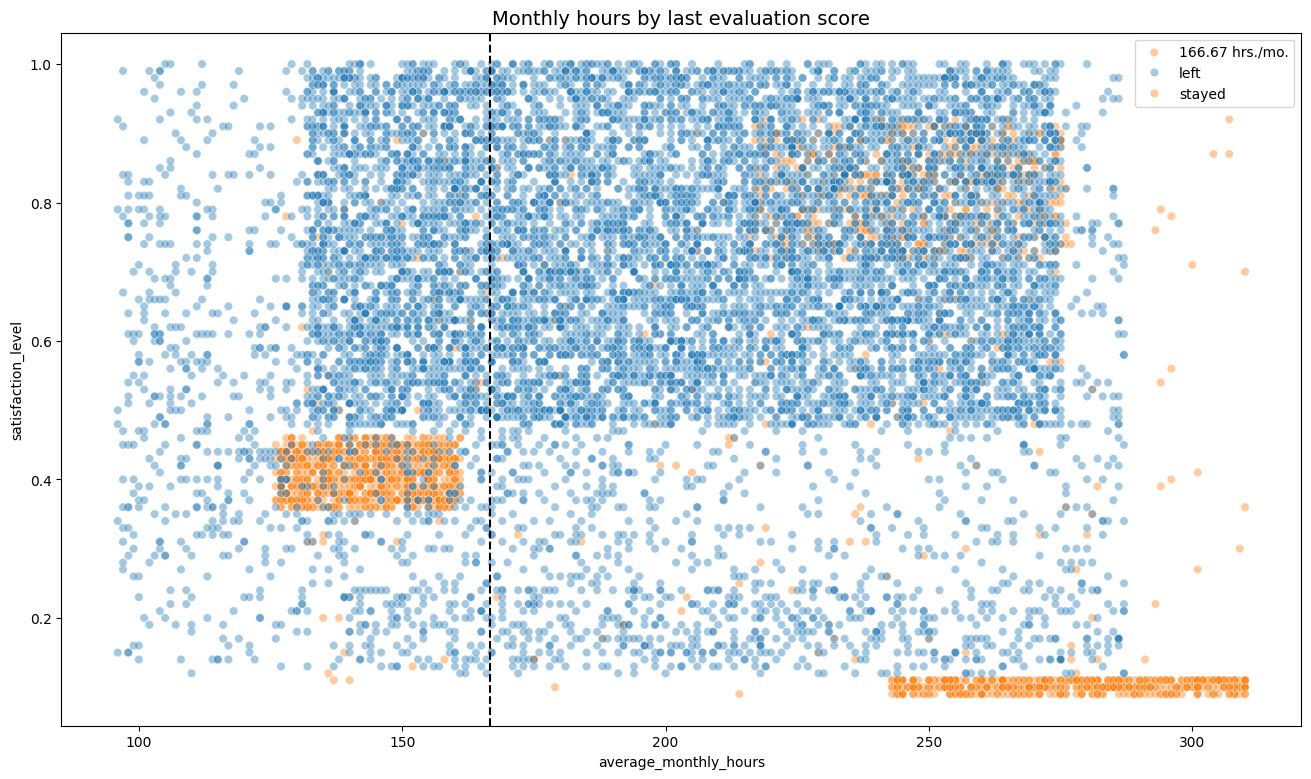

In [25]:
plt.figure(figsize=(16, 9))
sns.scatterplot(data=df1, x='average_monthly_hours', y='satisfaction_level', hue='left', alpha=0.4)
plt.axvline(x=166.67, color='black', label='166.67 hrs./mo.', ls='--')
plt.legend(labels=['166.67 hrs./mo.', 'left', 'stayed'])
plt.title('Monthly hours by last evaluation score', fontsize='14');

##### Note that, vertical line of 166.67 hrs./mo. is calculated from the average of 50 weeks * 40 hours per week / 12 months = 166.67 hours per month (considering 2 weeks of vacation per year). Observation: Bottom right left groups worked from around 240 to 315 hours per week, which is really high. This might be the reason that their satisfaction levels being close to zero; There is another left group who worked at normally hours per week, but the satisifaction was around 0.4; The last cluster left group who worked ~210–280 hours per month, and they had satisfaction levels ranging ~0.7–0.9.


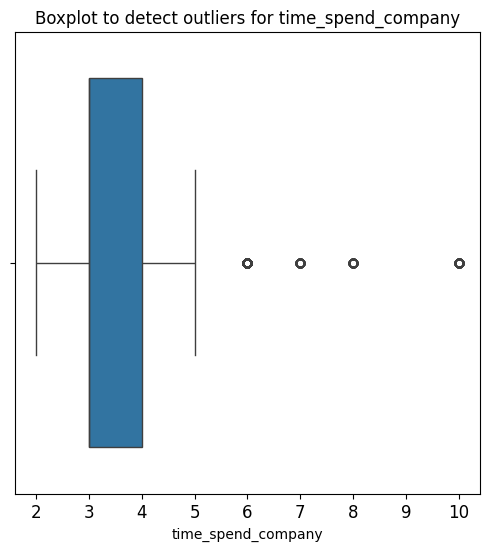

In [ ]:
# Create a boxplot to visualize distribution of `tenure` and detect any outliers
plt.figure(figsize=(6,6))
plt.title('Boxplot to detect outliers for time_spend_company', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
sns.boxplot(x=df1['time_spend_company'])
plt.show()

In [ ]:
# Determine the number of rows containing outliers
### YOUR CODE HERE ###

# Compute the 25th percentile value in `tenure`
percentile25 = df1['time_spend_company'].quantile(0.25)

# Compute the 75th percentile value in `tenure`
percentile75 = df1['time_spend_company'].quantile(0.75)

# Compute the interquartile range in `tenure`
iqr = percentile75 - percentile25

# Define the upper limit and lower limit for non-outlier values in `tenure`
upper_limit = percentile75 + 1.5 * iqr
lower_limit = percentile25 - 1.5 * iqr
print("Lower limit:", lower_limit)
print("Upper limit:", upper_limit)

# Identify subset of data containing outliers in `tenure`
outliers = df1[(df1['time_spend_company'] > upper_limit) | (df1['time_spend_company'] < lower_limit)]

# Count how many rows in the data contain outliers in `tenure`
print("Number of rows in the data containing outliers in `time_spend_company`:", len(outliers))

Lower limit: 1.5
Upper limit: 5.5
Number of rows in the data containing outliers in `time_spend_company`: 824


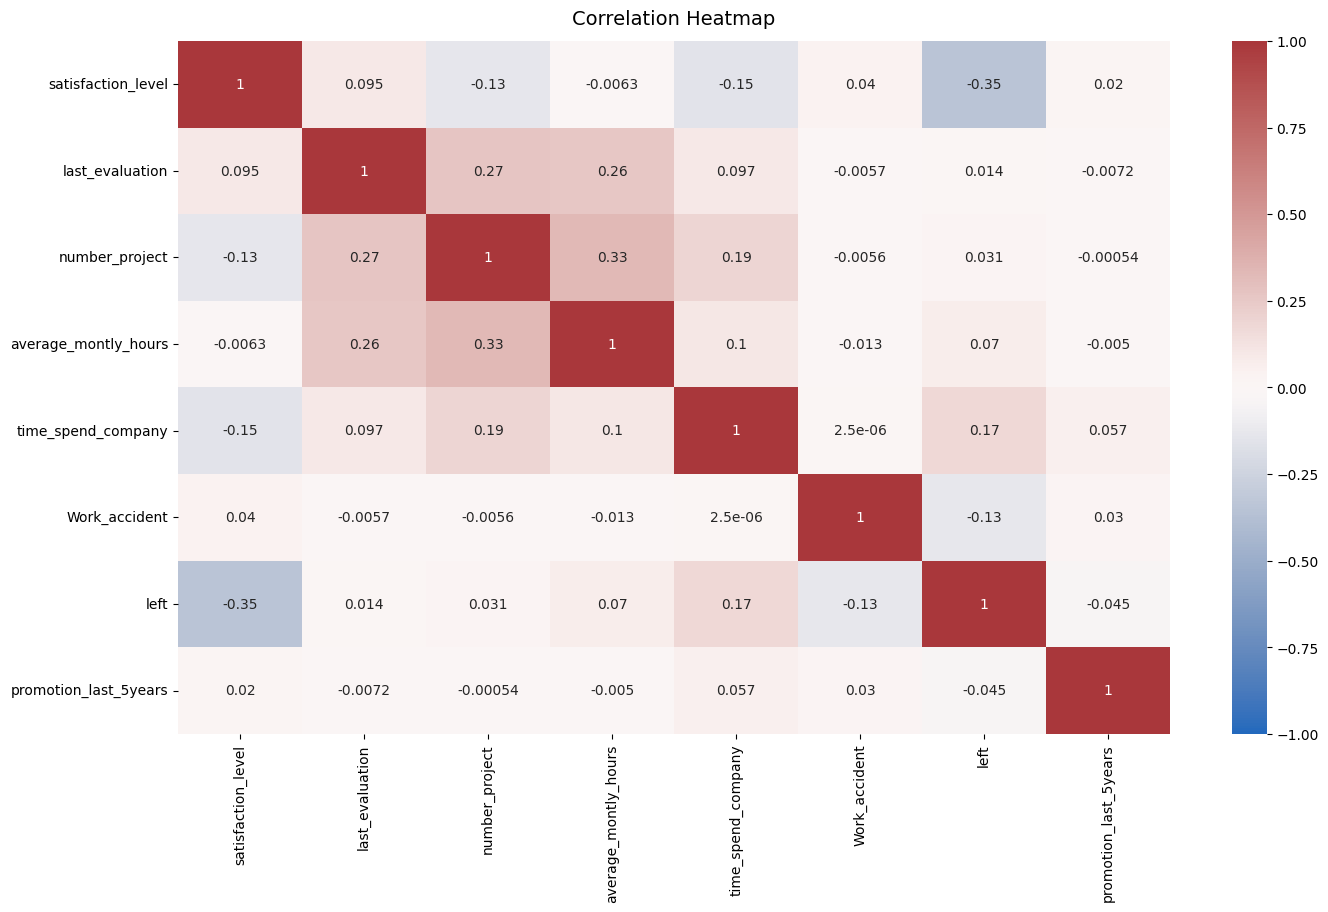

In [ ]:
# Create a plot as needed
### YOUR CODE HERE ###

# Plot a correlation heatmap
plt.figure(figsize=(16, 9))
heatmap = sns.heatmap(df1.corr(numeric_only=True), vmin=-1, vmax=1, annot=True, cmap=sns.color_palette("vlag", as_cmap=True))
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':14}, pad=12);

In [ ]:
# Copy the dataframe
df_enc = df1.copy()

# Encode the `salary` column as an ordinal numeric category
df_enc['salary'] = (
    df_enc['salary'].astype('category')
    .cat.set_categories(['low', 'medium', 'high'])
    .cat.codes
)

# Dummy encode the `department` column
df_enc = pd.get_dummies(df_enc, drop_first=False)

# Display the new dataframe
df_enc.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary,Department_IT,Department_RandD,Department_accounting,Department_hr,Department_management,Department_marketing,Department_product_mng,Department_sales,Department_support,Department_technical
0,0.38,0.53,2,157,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
1,0.80,0.86,5,262,6,0,1,0,1,False,False,False,False,False,False,False,True,False,False
2,0.11,0.88,7,272,4,0,1,0,1,False,False,False,False,False,False,False,True,False,False
3,0.72,0.87,5,223,5,0,1,0,0,False,False,False,False,False,False,False,True,False,False
4,0.37,0.52,2,159,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False


In [ ]:
df1

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low
...,...,...,...,...,...,...,...,...,...,...
11995,0.90,0.55,3,259,10,1,0,1,management,high
11996,0.74,0.95,5,266,10,0,0,1,management,high
11997,0.85,0.54,3,185,10,0,0,1,management,high
11998,0.33,0.65,3,172,10,0,0,1,marketing,high


In [ ]:
# Select rows without outliers in `tenure` and save resulting dataframe in a new variable
df_logreg = df_enc[(df_enc['time_spend_company'] >= lower_limit) & (df_enc['time_spend_company'] <= upper_limit)]

# Display first few rows of new dataframe
df_logreg.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,salary,Department_IT,Department_RandD,Department_accounting,Department_hr,Department_management,Department_marketing,Department_product_mng,Department_sales,Department_support,Department_technical
0,0.38,0.53,2,157,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
2,0.11,0.88,7,272,4,0,1,0,1,False,False,False,False,False,False,False,True,False,False
3,0.72,0.87,5,223,5,0,1,0,0,False,False,False,False,False,False,False,True,False,False
4,0.37,0.52,2,159,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
5,0.41,0.50,2,153,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False


In [ ]:
# Isolate the outcome variable
y = df_logreg['left']

# Display first few rows of the outcome variable
y.head()

,left
0,1
2,1
3,1
4,1
5,1


In [ ]:
# Select the features you want to use in your model
X = df_logreg.drop('left', axis=1)

# Display the first few rows of the selected features
X.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,promotion_last_5years,salary,Department_IT,Department_RandD,Department_accounting,Department_hr,Department_management,Department_marketing,Department_product_mng,Department_sales,Department_support,Department_technical
0,0.38,0.53,2,157,3,0,0,0,False,False,False,False,False,False,False,True,False,False
2,0.11,0.88,7,272,4,0,0,1,False,False,False,False,False,False,False,True,False,False
3,0.72,0.87,5,223,5,0,0,0,False,False,False,False,False,False,False,True,False,False
4,0.37,0.52,2,159,3,0,0,0,False,False,False,False,False,False,False,True,False,False
5,0.41,0.50,2,153,3,0,0,0,False,False,False,False,False,False,False,True,False,False


In [ ]:
# Split the data into training set and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

In [ ]:
# Construct a logistic regression model and fit it to the training dataset
log_clf = LogisticRegression(random_state=42, max_iter=500).fit(X_train, y_train)

In [ ]:
# Use the logistic regression model to get predictions on the test set
y_pred = log_clf.predict(X_test)

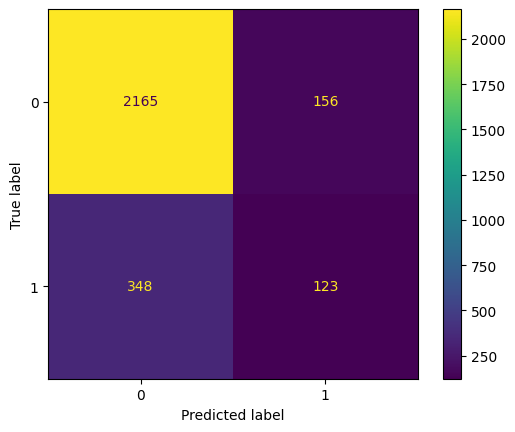

In [ ]:
# Compute values for confusion matrix
log_cm = confusion_matrix(y_test, y_pred, labels=log_clf.classes_)

# Create display of confusion matrix
log_disp = ConfusionMatrixDisplay(confusion_matrix=log_cm,
                                  display_labels=log_clf.classes_)

# Plot confusion matrix
log_disp.plot(values_format='')

# Display plot
plt.show()



In [ ]:
# Create classification report for logistic regression model
y_pred = log_clf.predict(X_test)
target_names = ['Predicted would not leave', 'Predicted would leave']
print(classification_report(y_test, y_pred, target_names=target_names))

                           precision    recall  f1-score   support

Predicted would not leave       0.86      0.93      0.90      2321
    Predicted would leave       0.44      0.26      0.33       471

                 accuracy                           0.82      2792
                macro avg       0.65      0.60      0.61      2792
             weighted avg       0.79      0.82      0.80      2792



In [ ]:
from sklearn.metrics import roc_auc_score

score = roc_auc_score(y_test, y_pred)
print(score)

0.5969670441853253


In [ ]:
# Instantiate model
tree = DecisionTreeClassifier(random_state=0)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth':[4, 6, 8, None],
             'min_samples_leaf': [2, 5, 1],
             'min_samples_split': [2, 4, 6]
             }

# Assign a dictionary of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Instantiate GridSearch
tree1 = GridSearchCV(tree, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [ ]:
tree1.fit(X_train, y_train)


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [ ]:
tree1.best_params_
tree1.best_score_

0.9738070859906354

In [ ]:
preds = tree1.best_estimator_.predict(X_test)
print(classification_report(y_test, preds, target_names=target_names))


score = roc_auc_score(y_test, preds)
print(score)

                           precision    recall  f1-score   support

Predicted would not leave       0.99      0.99      0.99      2321
    Predicted would leave       0.96      0.93      0.95       471

                 accuracy                           0.98      2792
                macro avg       0.97      0.96      0.97      2792
             weighted avg       0.98      0.98      0.98      2792

0.9613059383035535


In [ ]:
def make_results(model_name:str, model_object, metric:str):
    '''
    Arguments:
        model_name (string): what you want the model to be called in the output table
        model_object: a fit GridSearchCV object
        metric (string): precision, recall, f1, accuracy, or auc

    Returns a pandas df with the F1, recall, precision, accuracy, and auc scores
    for the model with the best mean 'metric' score across all validation folds.
    '''

    # Create dictionary that maps input metric to actual metric name in GridSearchCV
    metric_dict = {'auc': 'mean_test_roc_auc',
                   'precision': 'mean_test_precision',
                   'recall': 'mean_test_recall',
                   'f1': 'mean_test_f1',
                   'accuracy': 'mean_test_accuracy'
                  }

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(metric) score
    best_estimator_results = cv_results.iloc[cv_results[metric_dict[metric]].idxmax(), :]

    # Extract Accuracy, precision, recall, and f1 score from that row
    auc = best_estimator_results.mean_test_roc_auc
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame()
    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'F1': [f1],
                          'accuracy': [accuracy],
                          'auc': [auc]
                        })

    return table

In [ ]:
# Get all CV scores
tree1_cv_results = make_results('decision tree cv', tree1, 'auc')
tree1_cv_results

,model,precision,recall,F1,accuracy,auc
0,decision tree cv,0.959115,0.912839,0.935275,0.978747,0.973807


In [ ]:
# Instantiate model
rf = RandomForestClassifier(random_state=0)

# Assign a dictionary of hyperparameters to search over
cv_params = {'max_depth': [3,5, None],
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [300, 500],
             }

# Assign a dictionary of scoring metrics to capture
scoring = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']

# Instantiate GridSearch
rf1 = GridSearchCV(rf, cv_params, scoring=scoring, cv=4, refit='roc_auc')

In [ ]:
%%time
rf1.fit(X_train, y_train) # --> Wall time: ~10min

CPU times: user 26min 36s, sys: 2.41 s, total: 26min 39s
Wall time: 26min 47s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300, 500]},
             refit='roc_auc',
             scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'])

In [ ]:
def write_pickle(path, model_object, save_as:str):
    '''
    In:
        path:         path of folder where you want to save the pickle
        model_object: a model you want to pickle
        save_as:      filename for how you want to save the model

    Out: A call to pickle the model in the folder indicated
    '''

    with open(path + save_as + '.pickle', 'wb') as to_write:
        pickle.dump(model_object, to_write)

def read_pickle(path, saved_model_name:str):
    '''
    In:
        path:             path to folder where you want to read from
        saved_model_name: filename of pickled model you want to read in

    Out:
        model: the pickled model
    '''
    with open(path + saved_model_name + '.pickle', 'rb') as to_read:
        model = pickle.load(to_read)

    return model

In [ ]:
path = './models_results/'
# Write pickle
write_pickle(path, rf1, 'hr_rf1')

In [ ]:
# Read pickle
rf1 = read_pickle(path, 'hr_rf1')

In [ ]:
# Check best AUC score on CV
rf1.best_score_

0.9802415320040019

In [ ]:
# Check best params
rf1.best_params_

{'max_depth': 5,
 'max_features': 1.0,
 'max_samples': 1.0,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 300}

In [ ]:
# Get all CV scores
rf1_cv_results = make_results('random forest cv', rf1, 'auc')
print(tree1_cv_results)
print(rf1_cv_results)

              model  precision    recall        F1  accuracy       auc
0  decision tree cv   0.959115  0.912839  0.935275  0.978747  0.973807
              model  precision    recall        F1  accuracy       auc
0  random forest cv   0.968981  0.908588  0.937703  0.979702  0.980242


In [ ]:
def get_scores(model_name:str, model, X_test_data, y_test_data):
    '''
    Generate a table of test scores.

    In:
        model_name (string):  How you want your model to be named in the output table
        model:                A fit GridSearchCV object
        X_test_data:          numpy array of X_test data
        y_test_data:          numpy array of y_test data

    Out: pandas df of precision, recall, f1, accuracy, and AUC scores for your model
    '''

    preds = model.best_estimator_.predict(X_test_data)

    auc = roc_auc_score(y_test_data, preds)
    accuracy = accuracy_score(y_test_data, preds)
    precision = precision_score(y_test_data, preds)
    recall = recall_score(y_test_data, preds)
    f1 = f1_score(y_test_data, preds)

    table = pd.DataFrame({'model': [model_name],
                          'precision': [precision],
                          'recall': [recall],
                          'f1': [f1],
                          'accuracy': [accuracy],
                          'AUC': [auc]
                         })

    return table

In [ ]:
# Get predictions on test data
rf1_test_scores = get_scores('random forest1 test', rf1, X_test, y_test)
rf1_test_scores

,model,precision,recall,f1,accuracy,AUC
0,random forest1 test,0.98427,0.929936,0.956332,0.985673,0.96346


In [ ]:
preds = rf1.best_estimator_.predict(X_test)
print(classification_report(y_test, preds, target_names=target_names))


                           precision    recall  f1-score   support

Predicted would not leave       0.99      1.00      0.99      2321
    Predicted would leave       0.98      0.93      0.96       471

                 accuracy                           0.99      2792
                macro avg       0.99      0.96      0.97      2792
             weighted avg       0.99      0.99      0.99      2792



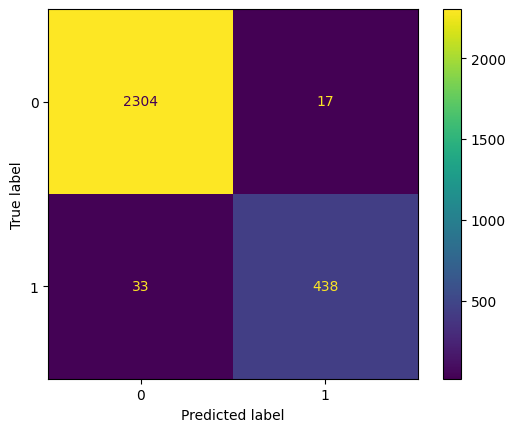

In [ ]:
# Generate array of values for confusion matrix
preds = tree1.best_estimator_.predict(X_test)
cm = confusion_matrix(y_test, preds, labels=tree1.classes_)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=tree1.classes_)
disp.plot(values_format='');

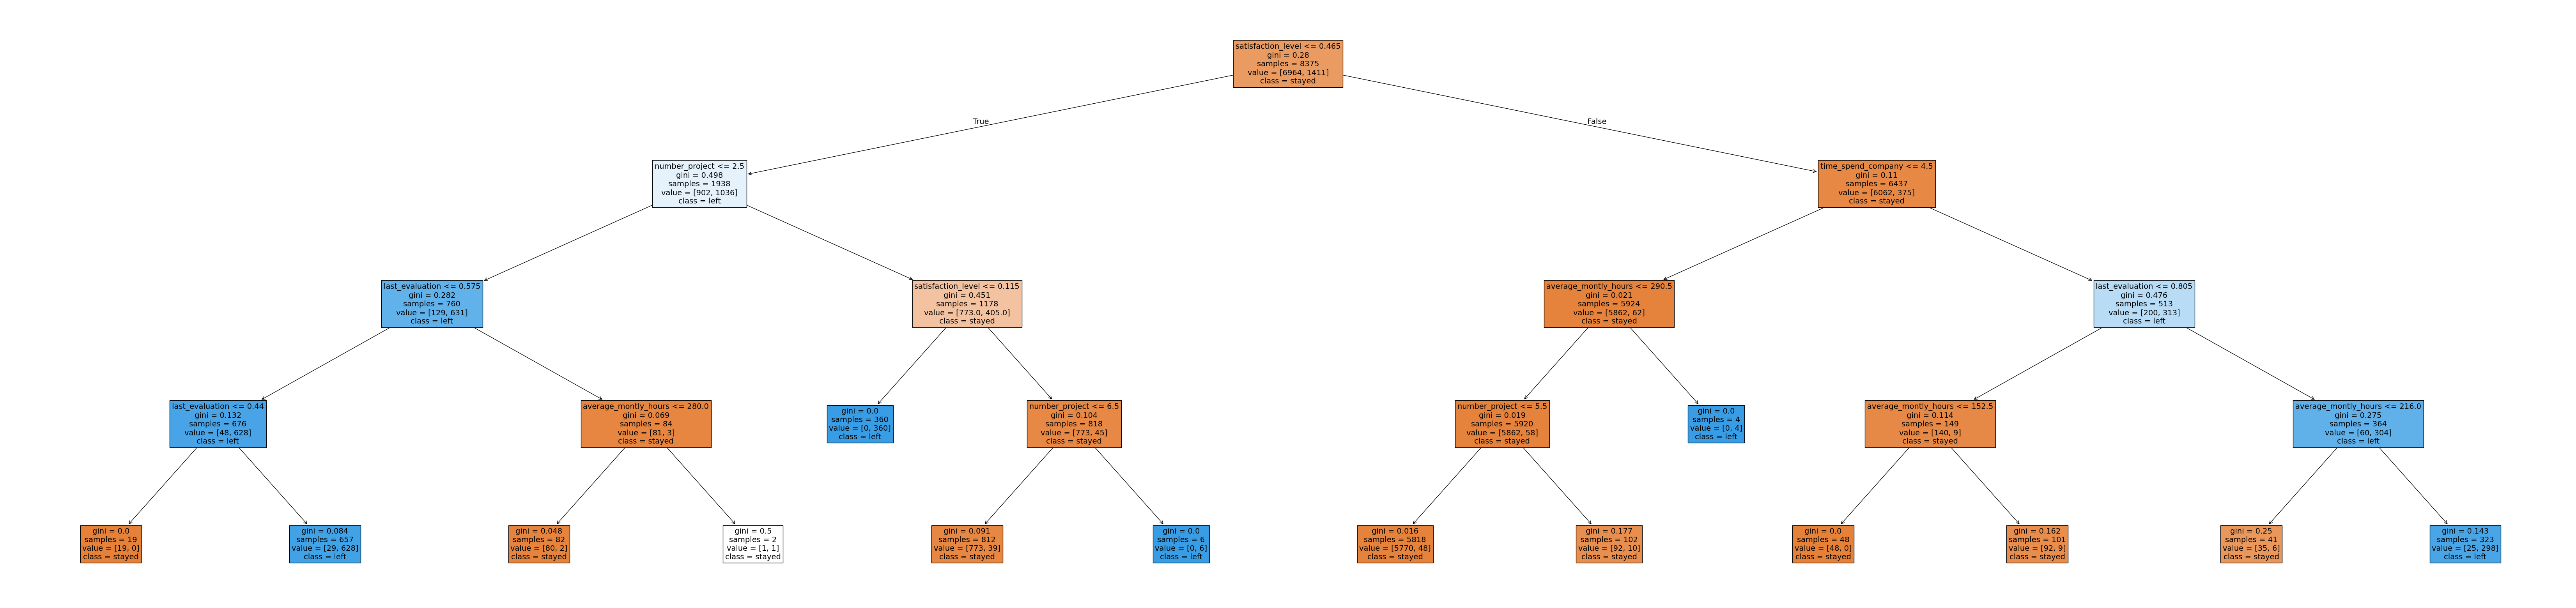

In [ ]:
# Plot the tree
plt.figure(figsize=(85,20))
plot_tree(tree1.best_estimator_, max_depth=4, fontsize=14, feature_names=X.columns,
          class_names={0:'stayed', 1:'left'}, filled=True);
plt.show()

In [ ]:
#tree2_importances = pd.DataFrame(tree2.best_estimator_.feature_importances_, columns=X.columns)
tree1_importances = pd.DataFrame(tree1.best_estimator_.feature_importances_,
                                 columns=['gini_importance'],
                                 index=X.columns
                                )
tree1_importances = tree1_importances.sort_values(by='gini_importance', ascending=False)

# Only extract the features with importances > 0
tree1_importances = tree1_importances[tree1_importances['gini_importance'] != 0]
tree1_importances

,gini_importance
satisfaction_level,0.553990
time_spend_company,0.167601
last_evaluation,0.138160
number_project,0.114046
average_montly_hours,0.026202


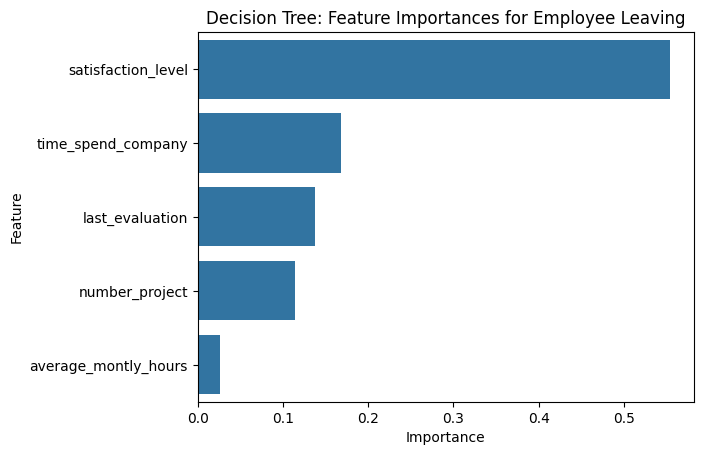

In [ ]:
sns.barplot(data=tree1_importances, x="gini_importance", y=tree1_importances.index, orient='h')
plt.title("Decision Tree: Feature Importances for Employee Leaving", fontsize=12)
plt.ylabel("Feature")
plt.xlabel("Importance")
plt.show()

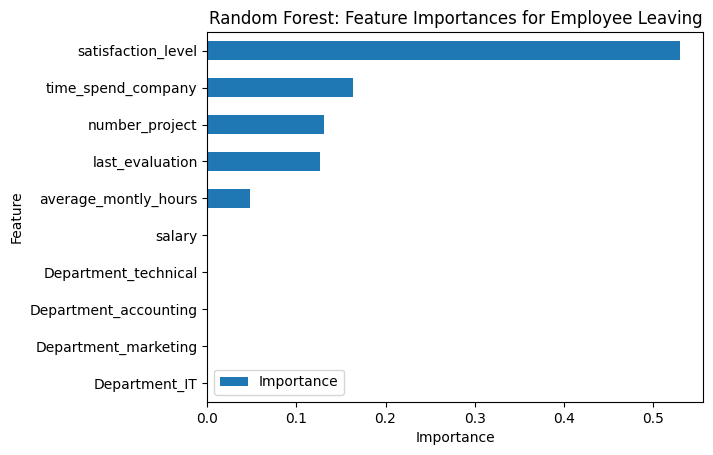

In [ ]:
# Get feature importances
feat_impt = rf1.best_estimator_.feature_importances_

# Get indices of top 10 features
ind = np.argpartition(rf1.best_estimator_.feature_importances_, -10)[-10:]

# Get column labels of top 10 features
feat = X.columns[ind]

# Filter `feat_impt` to consist of top 10 feature importances
feat_impt = feat_impt[ind]

y_df = pd.DataFrame({"Feature":feat,"Importance":feat_impt})
y_sort_df = y_df.sort_values("Importance")
fig = plt.figure()
ax1 = fig.add_subplot(111)

y_sort_df.plot(kind='barh',ax=ax1,x="Feature",y="Importance")

ax1.set_title("Random Forest: Feature Importances for Employee Leaving", fontsize=12)
ax1.set_ylabel("Feature")
ax1.set_xlabel("Importance")

plt.show()